In [20]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, f1_score, roc_auc_score

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'



sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.style.use('ggplot')
HAPPY_COLORS_PALETTE = ['#BF616A','#D08770','#EBCB8B','#A3BE8C','#B48EAD', "#8FBCBB"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [21]:
df = pd.read_csv('temp.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
df.head()

,SUBJECT_ID,TEXT,CANCER,HEART DISEASE,LUNG DISEASE,ALCOHOL ABUSE,CHRONIC_NEURO_DYSTROPHIES,CHRONIC PAIN,DEMENTIA,DEPRESSION,DEVELOPMENT RETARDATION,NON ADHERENCE,NONE,OBESITY,SUBSTANCE ABUSE,PSYCHIATRIC DISORDERS,UNSURE
0,5774,RVG ...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5774,RVG ...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5774,RVG ...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,5774,RVG ...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5774,RVG ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((5379, 17), (284, 17))

<AxesSubplot:>

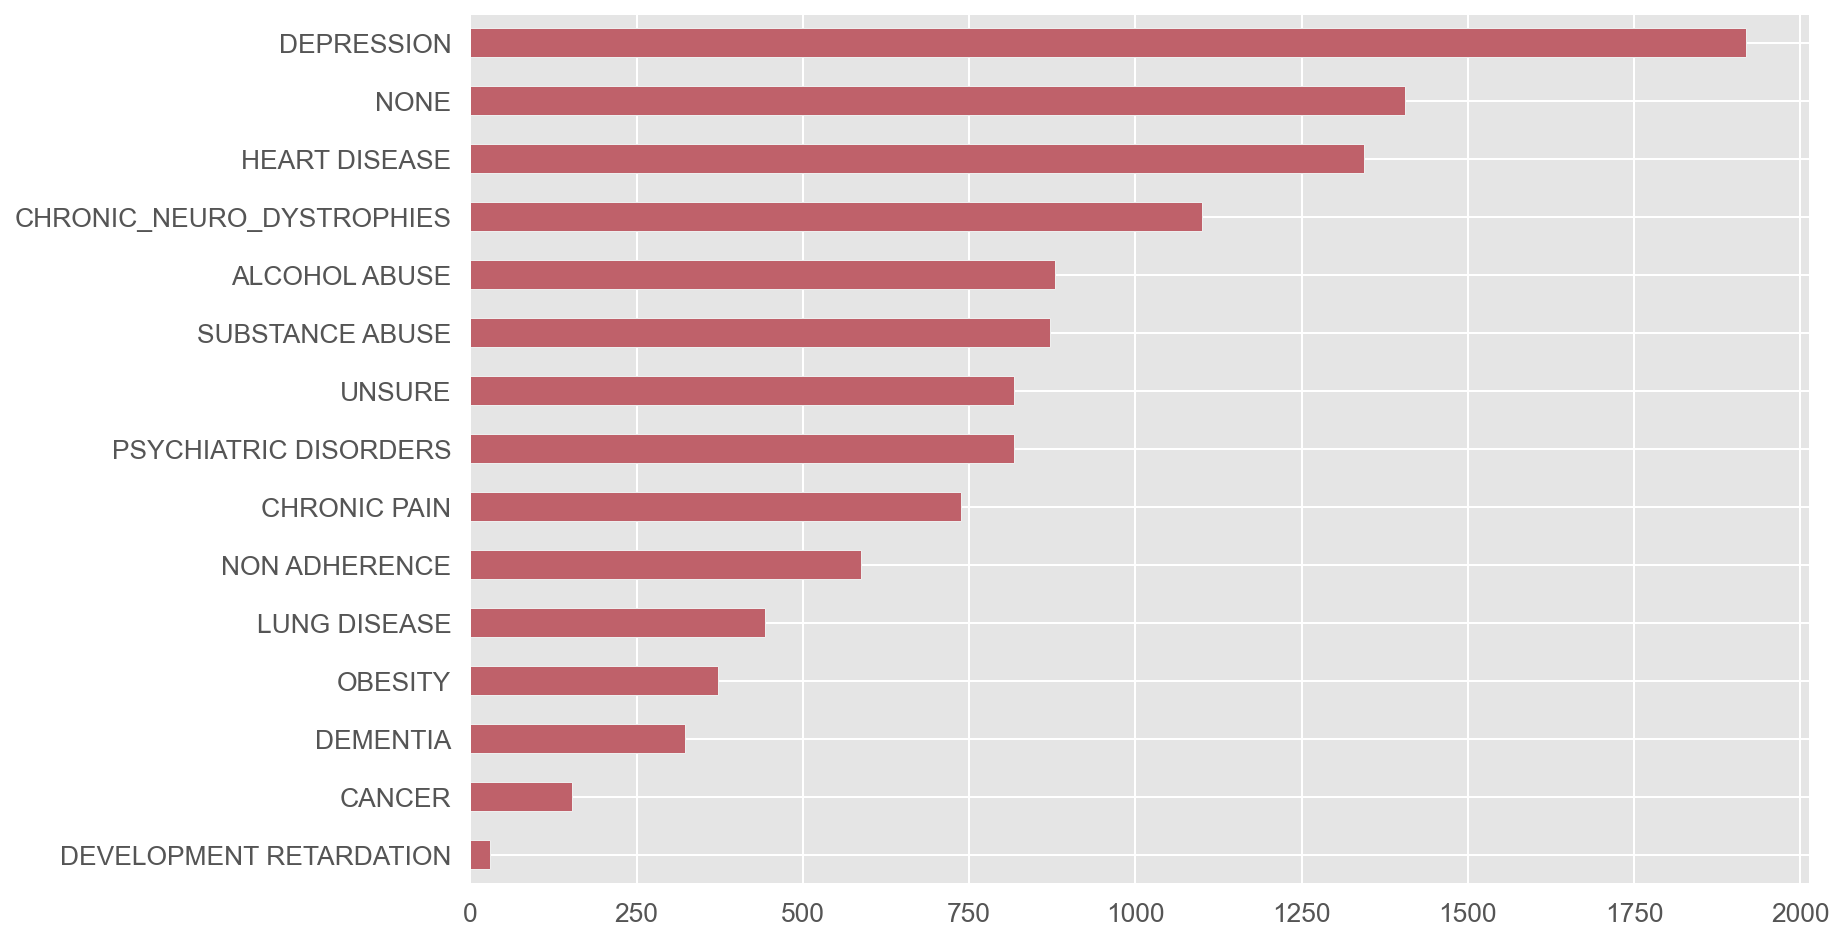

In [24]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

In [25]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [26]:
sample_row = df.iloc[16]
sample_report = sample_row.TEXT
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_report)
print()
print(sample_labels.to_dict())

Sinus tachycardia with increase in rate as compared to the previous tracing
of [**--**]. There is non-specific ST-T wave flattening. Delayed precordial
R wave progression. Left atrial abnormality. Lead V is now recorded. There is
frequent atrial ectopy. Otherwise, no diagnostic interim change.
TRACING #



{'CANCER': 1, 'HEART DISEASE': 0, 'LUNG DISEASE': 0, 'ALCOHOL ABUSE': 0, 'CHRONIC_NEURO_DYSTROPHIES': 0, 'CHRONIC PAIN': 0, 'DEMENTIA': 0, 'DEPRESSION': 0, 'DEVELOPMENT RETARDATION': 0, 'NON ADHERENCE': 0, 'NONE': 0, 'OBESITY': 0, 'SUBSTANCE ABUSE': 0, 'PSYCHIATRIC DISORDERS': 0, 'UNSURE': 1}


In [27]:
encoding = tokenizer.encode_plus(
  sample_report,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

In [28]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [29]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [30]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,  8254,  2271, 11937, 11714, 11522,  2401,  2007,  3623,  1999,
         3446,  2004,  4102,  2000,  1996,  3025, 16907,  1997,  1031,  1008])

In [31]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [32]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'sin', '##us', 'ta', '##chy', '##card', '##ia', 'with', 'increase', 'in', 'rate', 'as', 'compared', 'to', 'the', 'previous', 'tracing', 'of', '[', '*']


In [33]:
token_counts = []

for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
        row["TEXT"],
        max_length=512,
        truncation=True
      ))
    token_counts.append(token_count)

(0.0, 512.0)

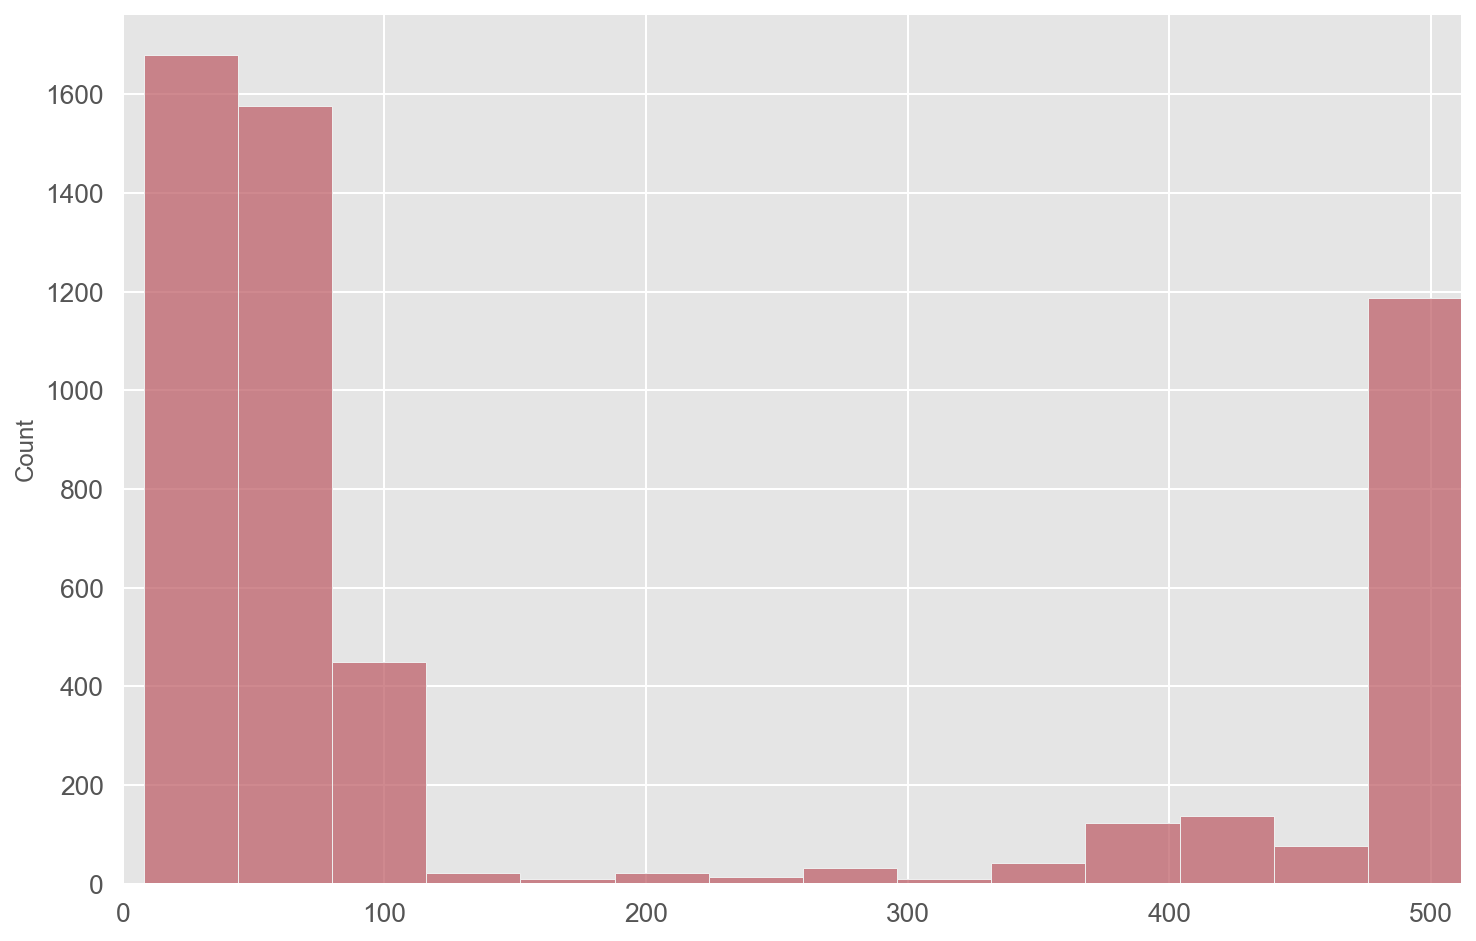

In [34]:
sns.histplot(token_counts)
plt.xlim([0, 512])

In [19]:
MAX_TOKEN_COUNT = 512